<a href="https://colab.research.google.com/github/rastringer/blog_notebooks/blob/main/demystifying_kfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demystifying Kubeflow Pipelines

This notebook is an attempt to explore and understand Kubeflow Pipelines (KFP). KFP and many other MLOps tools have exploded in popularity since around 2020, and despite years of periodic use, the author still finds KFP complicated, unintuitive and difficult to use.

Hence this notebook will be an exploration back to the basics and progressing to more complex pipelines.

### What is a pipeline?

Pipelines automate workflows. Machine learning is an interative process, from experimenting with data and models to deployments and monitoring real world efficacy of a service which makes predictions, or generates content. There are many steps in such work, from data preparation to hyperparameter tuning and model validation, all of which can be time consuming and tedious to do repetively. Pipelines affords practitioners a semi-automated process whereby they make some changes to the workflow and test results without significant effort. Pipelines also help to create a searchable lineage of experiments and deployments, and can be easily shared with other teams.  

### Infrastructure

A Kubernetes cluster is necessary to run KFP. For this notebook, I use Google Cloud's managed service, Vertex Pipelines. This allows us to focus on KFP rather than the underlying setup. To follow along in this notebook, you'll need a Google Cloud project with Vertex AI and Cloud Storage APIs [enabled](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,storage-component.googleapis.com&_ga=2.225375706.175896632.1705335976-1568003973.1704734102). See [here](https://cloud.google.com/vertex-ai/docs/pipelines/configure-project) for more details.

Let's use `pip` to install KFP and the GCP libraries.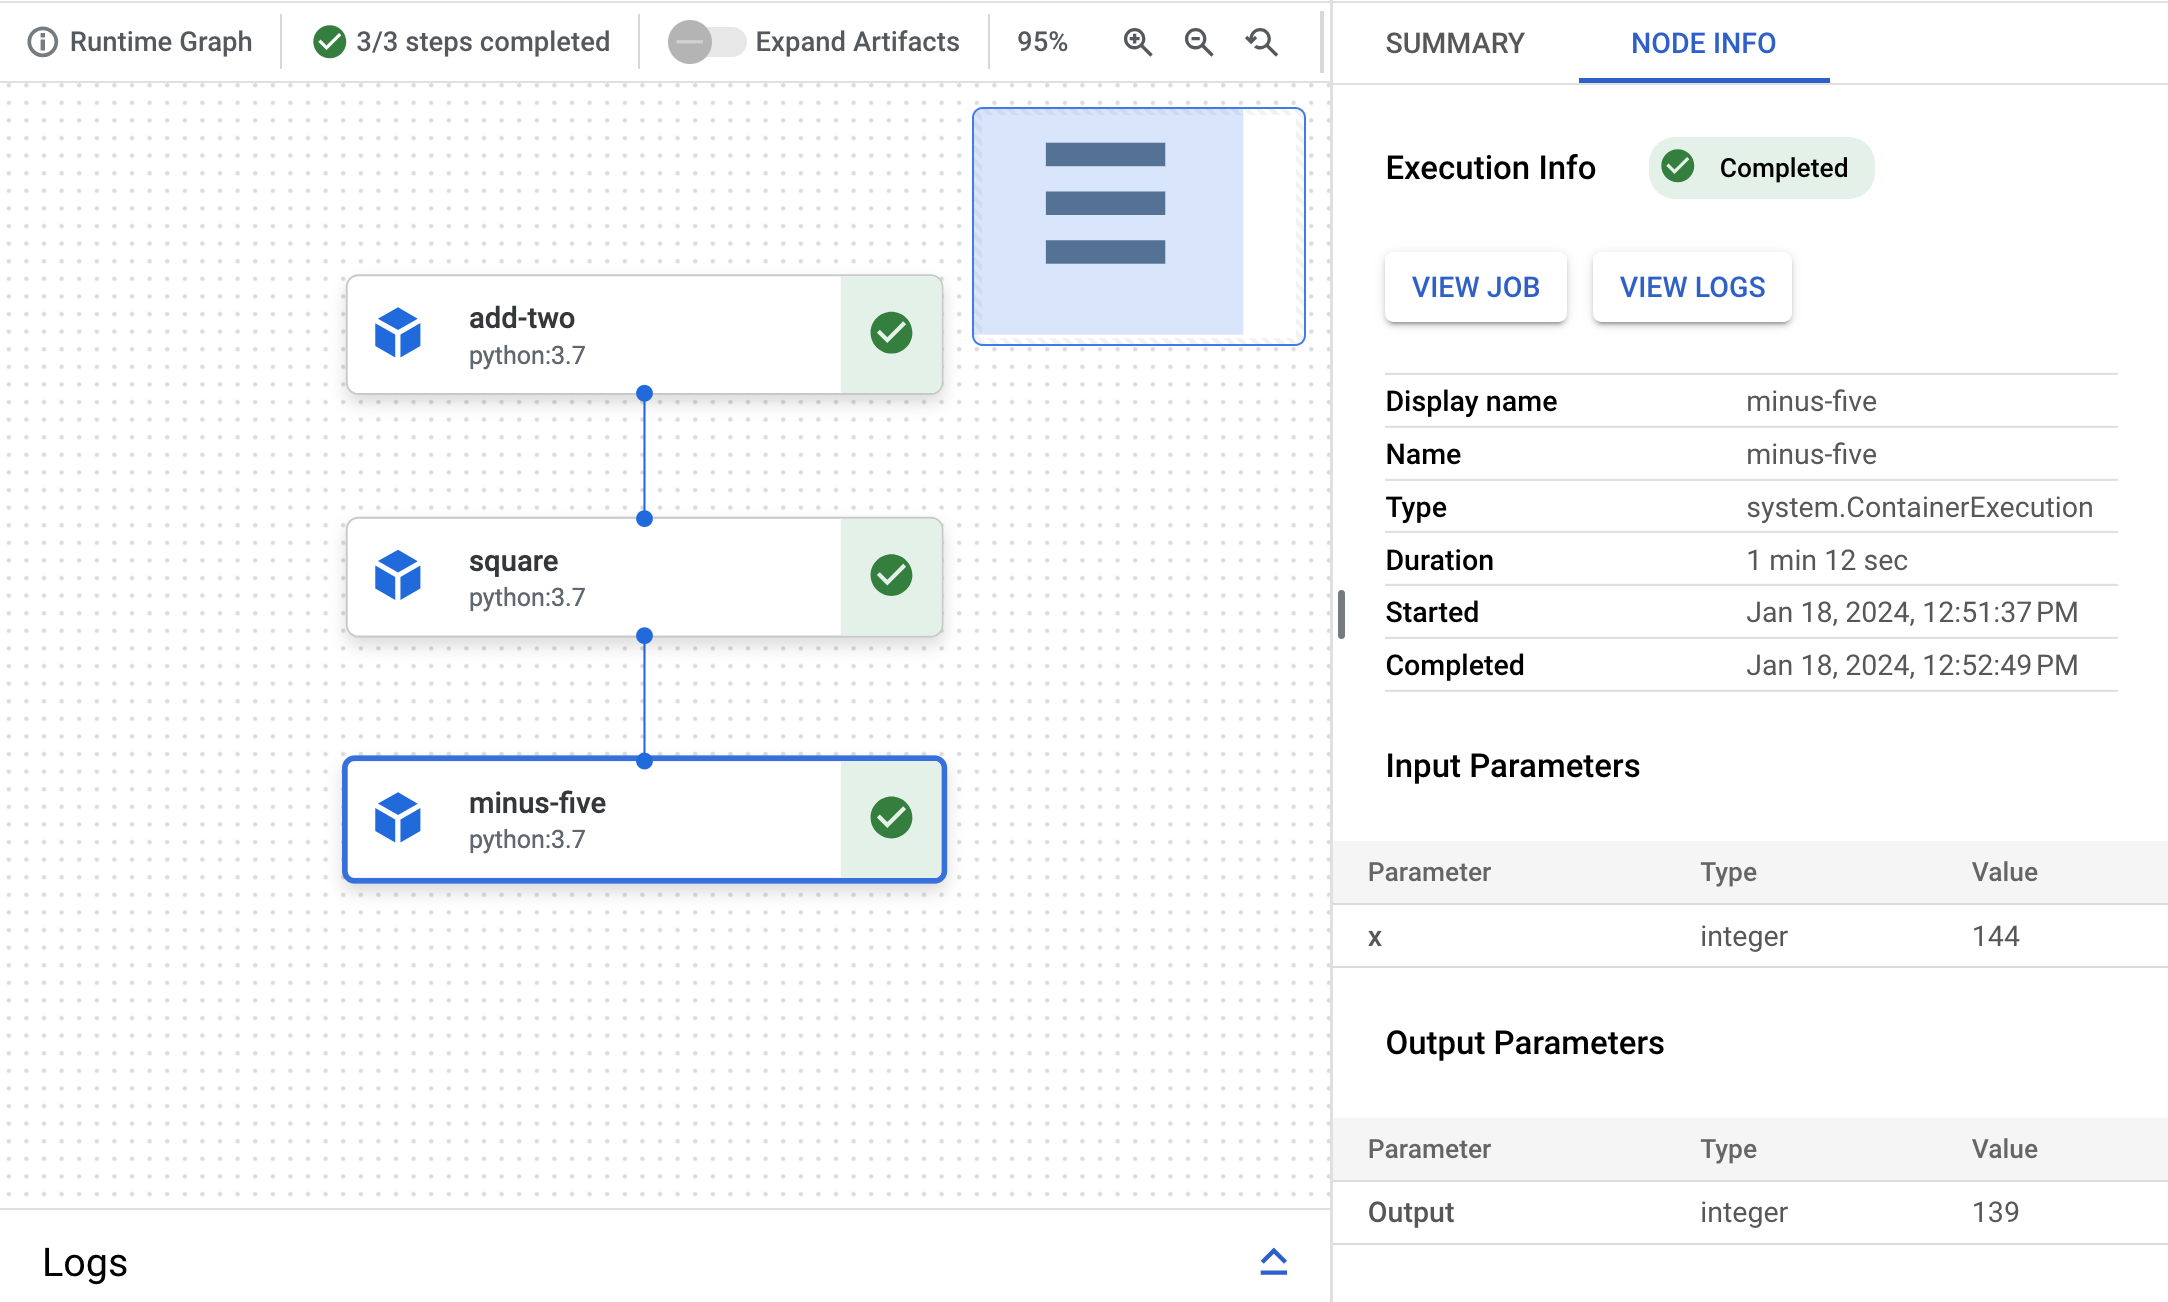

In [ ]:
!pip install google-cloud-aiplatform kfp

In [2]:
from google.colab import auth
auth.authenticate_user()

### Components

A pipeline is made of components. Typical components include loading data, training a model, and deployment. The various methods for authoring a component is a common source of confucion.

There are four approaches to writing components which will be considered here:

* Lightweight Python components
* Containerized Python components
* Container components
* Google Cloud Pipeline Components

### Lightweight components

The easiest way to create components is with the `@dsl.component` decorator. This transforms each decorated function into a containerized component that can be run as a step in a pipeline.

### The KFP `dsl`



In [4]:
from kfp import dsl, compiler

@dsl.component
def add_two(x: int) -> int:
  return x + 2

@dsl.component
def square(x: int) -> int:
  return x ** 2

@dsl.component
def minus_five(x: int) -> int:
  return x - 5

@dsl.pipeline
def pipeline(input: int) -> int:
  add_two_task = add_two(x=input)
  square_task = square(x=add_two_task.output)
  return minus_five(x=square_task.output).output


/usr/local/lib/python3.10/dist-packages/kfp/dsl/component_decorator.py:119: FutureWarning: Python 3.7 has reached end-of-life. The default base_image used by the @dsl.component decorator will switch from 'python:3.7' to 'python:3.8' on April 23, 2024. To ensure your existing components work with versions of the KFP SDK released after that date, you should provide an explicit base_image argument and ensure your component works as intended on Python 3.8.
  return component_factory.create_component_from_func(


### Compile the pipeline

To compile our simple pipeline, we need to set a few environment variables for our GCP project.
* `project_id`
* a `pipeline_root_path` path to a Cloud Storage bucket. This is where the artifacts generated by each component are stored.

In [5]:
project_id = "<your-project_id>"
region = "us-central1"
pipeline_root_path = "gs://<your-bucket-name>"

In [6]:
from kfp import compiler

compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path='simple_pipeline.yaml'
)

### Run the pipeline

There is some boilerplate to fill to provide the pipeline runner with the `.yaml` file and project details.

In [ ]:
from google.cloud import aiplatform

aiplatform.init(
    project=project_id,
    location=region,
)


# Create a Vertex AI Pipeline job
job = aiplatform.PipelineJob(
    display_name='simple_pipeline',
    template_path='simple_pipeline.yaml',
    pipeline_root=pipeline_root_path,
    enable_caching=True,
    parameter_values = {'input': 10}
)
# Run the pipeline job
job.run()

[!euclidean pipeline](images/euclidean_pipeline)

![simple_pipeline](images/simple_pipeline.png)

### Pipeline 2

Now that we have a very simple pipeline working, let's look at something slightly more complicated, again using lightweight components.

In [45]:
from typing import NamedTuple

@dsl.component
def calc_inputs(x: float, y: float) -> float:
    return x - y

@dsl.component
def square(x: float) -> float:
    return x ** 2

@dsl.component
def add(x: float, y: float) -> float:
    return x + y

@dsl.component
def square_root(x: float) -> float:
    import math
    return math.sqrt(x)

@dsl.pipeline
def euclidean_distance_pipeline(x1: float, y1: float, x2: float, y2: float) -> float:
    calc_x = calc_inputs(x=x2, y=x1)
    calc_y = calc_inputs(x=y2, y=y1)
    step1 = square(x=calc_x.output)
    step2 = square(x=calc_y.output)
    step3 = add(x=step1.output, y=step2.output)
    return square_root(x=step3.output).output

/usr/local/lib/python3.10/dist-packages/kfp/dsl/component_decorator.py:119: FutureWarning: Python 3.7 has reached end-of-life. The default base_image used by the @dsl.component decorator will switch from 'python:3.7' to 'python:3.8' on April 23, 2024. To ensure your existing components work with versions of the KFP SDK released after that date, you should provide an explicit base_image argument and ensure your component works as intended on Python 3.8.
  return component_factory.create_component_from_func(


In [47]:
from kfp import compiler

compiler.Compiler().compile(
    pipeline_func=euclidean_distance_pipeline,
    package_path='eucledian_pipeline.yaml'
)

In [ ]:
# Create a Vertex AI Pipeline job
job = aiplatform.PipelineJob(
    display_name='eucledian_pipeline',
    template_path='eucledian_pipeline.yaml',
    pipeline_root=pipeline_root_path,
    enable_caching=True,
    parameter_values = {'x1': 10.5, 'y1': 10.5, 'x2': 20.5, 'y2': 20.5}
)
# Run the pipeline job
job.run()

![euclidean_pipeline](images/euclidean_pipeline.png)